# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(font_scale=1.5)
sns.set_style('whitegrid', {'grid.linestyle': '--', 'grid.color': '.8'})

In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

In [4]:
X = boston["data"]
y = boston["target"]

In [5]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [6]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

34.99936108127786

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [7]:
# для генерации будстрапа есть замечательный метод в sklearn - resample, будем пользоваться ним
from sklearn.utils import resample
# Источник вдохновения - https://pastebin.com/X09CHvVj

def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    index = range(X.shape[0])
    # создадим массив, в который будем записывать результаты предсказаний
    prediction_matrix = []
    for i in range(num_runs):
        # генерация индексов бутстрапа и Out of Bag, зафиксируем random_state иначе будет тяжело сравнивать с bagging
        bootstrap = resample(index, replace=True, n_samples=len(index), random_state = i)
        out_of_bag = list(set(index) - set(bootstrap))
        # Предсказания целевой переменной - y
        prediction = regressor.fit(X[bootstrap], y[bootstrap]).predict(X[out_of_bag])
        # Запишем результаты в матрицу:
        # 1) создаем "пустой" array
        current_predictions = np.empty(X.shape[0])
        # 2) заполняем его значениями nan
        current_predictions.fill(np.nan)
        # 3) Записываем на индексы Out of Bag наши предсказания
        np.put(current_predictions, out_of_bag, prediction)
        # 4) Вносим array в матрицу с предсказаниями
        prediction_matrix.append(current_predictions)

    # переводим матрицу в формат numpy
    prediction_matrix = np.asarray(prediction_matrix) 
    # посчитаем смещение
    biases = np.nanmean(prediction_matrix, axis=0)
    bias = np.nanmean((biases - y)**2)
    # посчитаем разброс
    variances = np.nanvar(prediction_matrix, axis=0)
    variance = np.nanmean(variances)
    # посчитаем ошибку
    target = np.tile(np.array([y]).transpose(), num_runs)
    errors = (prediction_matrix.transpose() - target)**2
    error = np.nanmean(errors)
    
    return bias, variance, error

In [8]:
# выводить результаты будем через функцию
def print_BVE(bias, variance, error, regressor_name = ""):
    print('''For {}:
Bias - {}
Variance - {}
Error - {}'''.format(regressor_name, bias, variance, error))

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

lr = LinearRegression()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor(n_jobs=-1)

In [10]:
lr_bias, lr_variance, lr_error = compute_biase_variance(lr, X, y)
print_BVE(lr_bias, lr_variance, lr_error, 'Linear Regression')

For Linear Regression:
Bias - 23.76979803354369
Variance - 0.9565250464951384
Error - 24.669360978695828


In [11]:
dt_bias, dt_variance, dt_error = compute_biase_variance(dt, X, y)
print_BVE(dt_bias, dt_variance, dt_error, 'Decision Tree') 

For Decision Tree:
Bias - 10.313530866582308
Variance - 13.085272177457512
Error - 23.314810416868067


In [12]:
rf_bias, rf_variance, rf_error = compute_biase_variance(rf, X, y)
print_BVE(rf_bias, rf_variance, rf_error, 'Random Forest')

For Random Forest:
Bias - 10.6059963761357
Variance - 2.1924410402612944
Error - 12.764409836985356


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__ Результаты полностью согласуются с тем, что мы обсуждали на занятиях, а теперь более подробно. 

1.	Для линейной модели предполагается, что она достаточно простая и как следствие не способна выдать хороший ответ, если, конечно, мы самостоятельно не подобрали нелинейные признаки, которые будут восстанавливать нелинейную зависимость. В данном случае, мы, действительно, этого не делали. Так, у нас для линейной модели получилось большое смещение и маленький разброс (дисперсия) и как следствие большая ошибка алгоритма. Линейная модель плохо предсказывает целевую переменную, такие модели подходят только для восстановления линейной зависимости.
2.	Дерево является сложной моделью и в теории для такого алгоритма характерно небольшое смещение и большая дисперсия. Наш алгоритм такие результаты и показал. И поскольку ошибка оказалась большой, то можно говорить, что наши деревья (по отдельности) переобучились. Из-за того, что возросший разброс компенсировал уменьшение смещения, ошибка осталась сопоставима с линейной моделью. Как мы говорили на лекциях: в настоящее время по одиночке решающие деревья не используются, их используют в качестве композиции.
3. Случайный лес как композиция из решающих деревьев показал себя лучше всех. В отличии от решающих деревьев он лишен недостатков в виде большой дисперсии и большой ошибки. При сохранении того же смещения, благодаря усреднению алгоритмов удается существенно уменьшить дисперсию и как следствие ошибку в прогнозе.

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__

In [13]:
from sklearn.ensemble import BaggingRegressor

blr = BaggingRegressor(lr, n_jobs=-1)
bdt = BaggingRegressor(dt, n_jobs=-1)
brf = BaggingRegressor(rf, n_jobs=-1)

In [14]:
blr_bias, blr_variance, blr_error = compute_biase_variance(blr, X, y)
print_BVE(blr_bias, blr_variance, blr_error, 'Linear Regression with Bagging')

For Linear Regression with Bagging:
Bias - 23.76739042158144
Variance - 1.0461063211813395
Error - 24.756902670685548


In [15]:
bdt_bias, bdt_variance, bdt_error = compute_biase_variance(bdt, X, y)
print_BVE(bdt_bias, bdt_variance, bdt_error, 'Decision Tree with Bagging') 

For Decision Tree with Bagging:
Bias - 10.619485153503287
Variance - 3.3663472824629035
Error - 13.95065967894392


In [16]:
brf_bias, brf_variance, brf_error = compute_biase_variance(brf, X, y)
print_BVE(brf_bias, brf_variance, brf_error, 'Random Forest with Bagging')

For Random Forest with Bagging:
Bias - 11.623870908537564
Variance - 1.390720451220753
Error - 12.985802508665179


**Ответ**: Алгоритм бэггинга направлен на уменьшение разброса при сохранении смещения. В теории бэггинг способен уменьшить разброс в $N$ раз, где $N$ длина композиции в бэггинге. В действительности такое почти невозможно, потому что разброс в бэггенге состоит из дисперсии, уменьшенной в $N$ раз, и ковариации между двумя базовыми алгоритмами. Как показывает практика очень редко бывает такое, что ковариация двух базовых алгоритмов отсутствует. Как мы можем видеть, разброс, действительно, уменьшился для таких моделей как `Decision Tree` и `Random Forest`. 

1. Для алгоритма `Linear Regression` смещение осталось таким же. Разброс такой модели не уменьшился, усреднение по композиции бэггинга по сути никаких результатов не дает, так как линейные алгоритмы не склоны к переобучению, у них в базовой версии (без бэггинга) разброс и так маленький. Поэтому бэггинг для линейной регрессии не дал никаких результатов.

2. Для решающего дерева бэггинг показал очень хорошие результаты, поскольку для `Decision Tree` основным недостатком было большое смещение, то усреднение по композиции позволило уменьшить дисперсию приблизительно в 4 раза. Таким образом с бэггингом решающее дерево способно даже конкурировать со случайным лесом. А учитывая, что алгоритм решающего дерева во много раз превосходит по скорости бэггинг над случайным лесом (и даже случайный лес без бэггинга), то такой алгоритм может быть неплохим инструментом для быстрой проверки гипотез и калибровки.

3. Поскольку для `Random Forest` у нас изначально была не очень большая дисперсия, то бэггинг не так эффективен. Несомненно, он позволил уменьшить разброс, но такие результаты важны только для прома и соревнований. В нашем же случае при уменьшении дисперсии менее чем в 2 раза, нам удалось потратить времени в 6 раз больше. 

PS. У меня в Jupyter установлена надстройка, которая позволяет видеть за какое время отрабатывает один Cell.

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте фукнцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

Нашел неплохую палитру, на которой хорошо видны черные точки, однако, она маленькая, растянем ее, если такая необходимость возникнет (не возникнет, но я потренировался).

In [17]:
def palette(num):
    if num > 12: 
        repeats = round((num / 12)+1)
        palette = sns.color_palette("Paired")[:]
        colors = np.tile(np.array(a).T, repeats).T[:num]
    else:
        colors = sns.color_palette("Paired")[:num]
    return colors

In [18]:
# Вдохновение - https://pastebin.com/PtMbSJzc
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    # выберем num_test_objects случайных объектов
    # лучше всего через перестановки, через random.choices придется изобрести велосипед
    random_index = np.random.permutation(X.shape[0])
    test_pairs = random_index[:num_test_objects]
    train_pairs = random_index[num_test_objects:]
    # Разделим выборку на обучение и тест
    X_test = X[test_pairs]
    y_test = y[test_pairs]
    X_train = X[train_pairs]
    y_train = y[train_pairs]
    
    index = range(X_train.shape[0])  
    
    # Будстрап
    for i in range(num_runs):
        bootstrap = resample(index, replace=True, n_samples=len(index))
        X_bs, y_bs = X_train[bootstrap], y_train[bootstrap]
        prediction = regressor.fit(X_bs, y_bs).predict(X_test)
        
        # Стороим графики
        plt.scatter(np.arange(num_test_objects), prediction, 
                    c = palette(num_test_objects), alpha = 0.8)  
    plt.title(title, fontsize=30)
    plt.xlabel('Object of test sample')
    plt.ylabel('Predictions for y')
 
    plt.scatter(np.arange(num_test_objects), y_test, c = 'black')

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

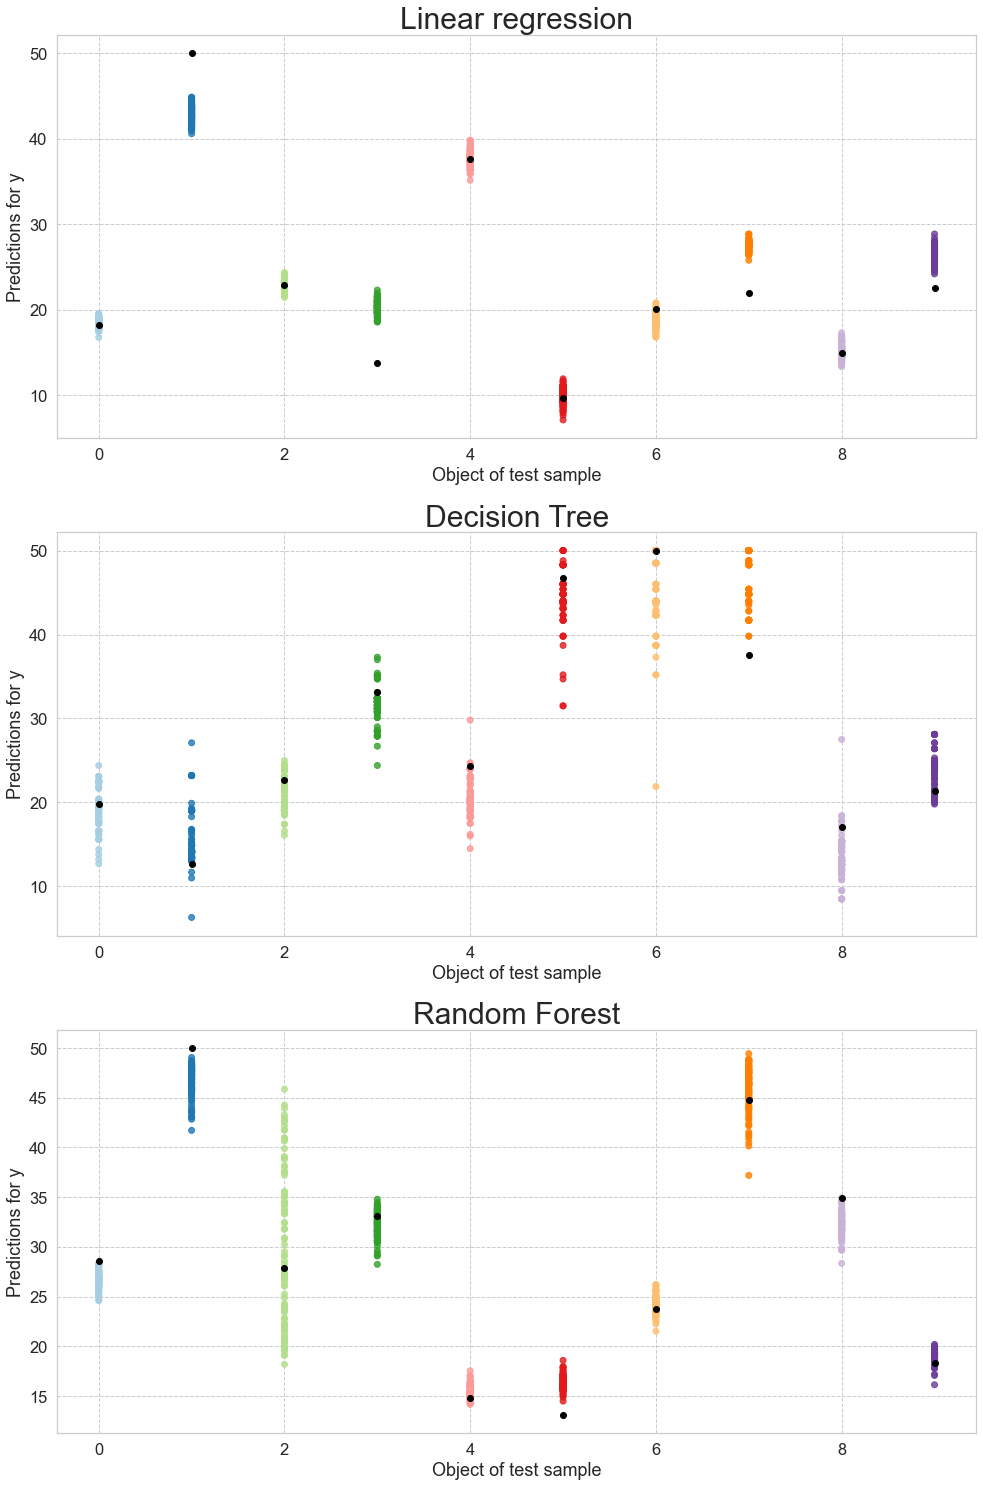

In [19]:
plt.figure(figsize=(14, 21))
plt.subplot(311)
plot_predictions(lr, X, y, title="Linear regression")
plt.subplot(312)
plot_predictions(dt, X, y, title="Decision Tree")
plt.subplot(313)
plot_predictions(rf, X, y, title="Random Forest")

plt.tight_layout()
plt.show()

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__ Цветные точки - показывают предсказание на выборке (попадания в мишень). Расстояние (близость) между цветными точками характеризует разброс алгоритма. Смещение оценить можно по близости цветных точек к черной точке (истинного ответа (центра мишени)).

1. Для линейной регрессии видно, что цветные точки располагаются достаточно кучно друг к другу, однако, как правило (все-таки присутствует доля случайности) черная точка находится либо где-то с краю, либо за пределами прогнозов. То есть для данного алгоритма характерна высокое смещение и небольшой разброс.
2. На графике для решающего дерева заметно, что точки располагаются как-то вразнобой, то есть для алгоритма свойственен большой разброс, но при этом черная точка (центр мишени) находится внутри интервала разброса цветных точек, что говорит нам о низком смещении.
3. Для случайного леса у нас ситуация похожая на ту, когда мы анализировали смещение, разброс и ошибку. То есть алгоритм показывает смещение похожее на смещение решающего дерева и разброс похожий на разброс линейной модели. Тем самым случайный лес "берет" лучшее от двух алгоритмов - небольшое смещение и небольшой разброс.

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

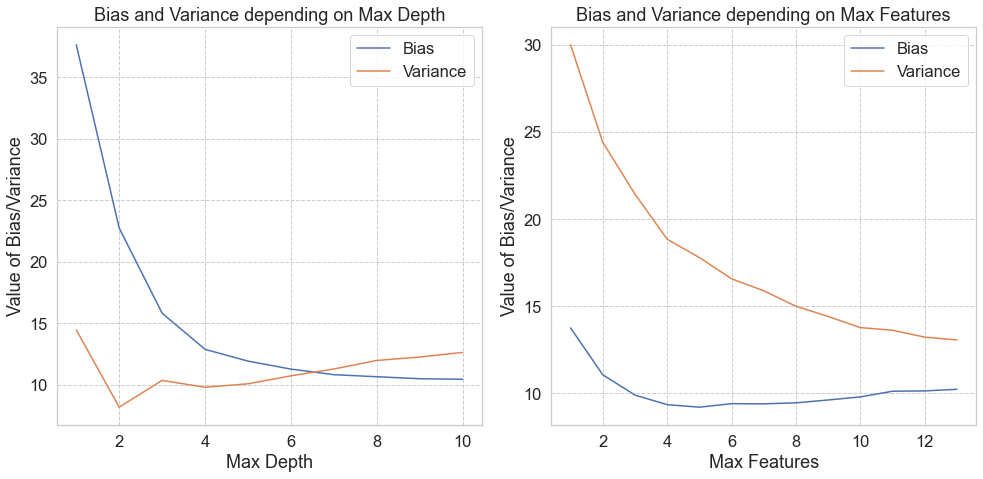

In [20]:
# Сетка для перебора параметров
max_depth_ = np.arange(1, 11)
max_features_ = np.arange(1, X.shape[1]+1)

# Переберем гиперпараметры max_depth и max_features по отдельности
biases_depth, variances_depth, biases_features, variances_features = [[] for i in range(4)]
for max_depth in max_depth_:
    dt_depth = DecisionTreeRegressor(max_depth=max_depth)
    bias_depth, variance_depth, _ = compute_biase_variance(dt_depth, X, y)
    biases_depth.append(bias_depth)
    variances_depth.append(variance_depth)
    
for max_features in max_features_:
    dt_features = DecisionTreeRegressor(max_features=max_features)
    bias_features, variance_features, _ = compute_biase_variance(dt_features, X, y)
    biases_features.append(bias_features)
    variances_features.append(variance_features)

# построим графики
plt.figure(figsize = (14, 7))

plt.subplot(121)
plt.plot(max_depth_, biases_depth, label = 'Bias')
plt.plot(max_depth_, variances_depth, label = 'Variance')
plt.xlabel('Max Depth')
plt.ylabel('Value of Bias/Variance')
plt.title('Bias and Variance depending on Max Depth')
plt.legend()

plt.subplot(122)
plt.plot(max_features_, biases_features, label = 'Bias')
plt.plot(max_features_, variances_features, label = 'Variance')
plt.xlabel('Max Features')
plt.ylabel('Value of Bias/Variance')
plt.title('Bias and Variance depending on Max Features')
plt.legend()

plt.tight_layout()
plt.show()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

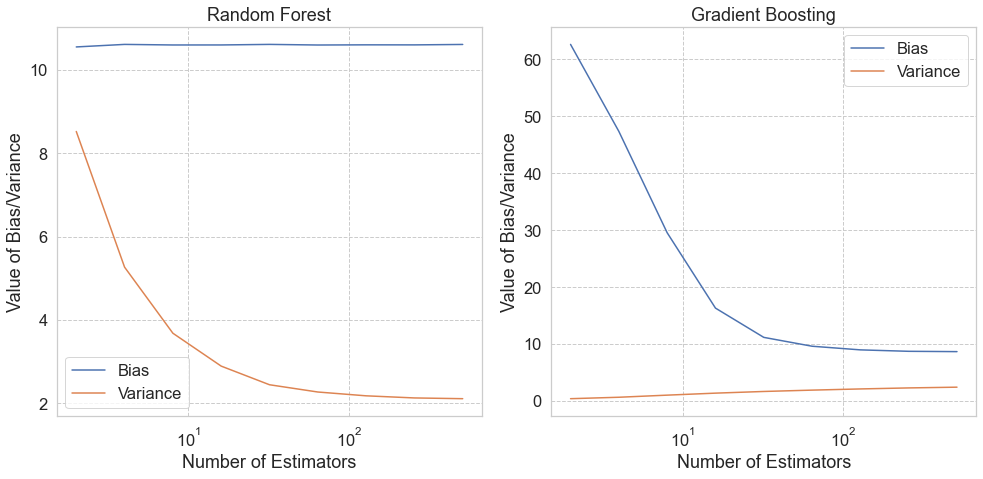

In [21]:
from sklearn.ensemble import GradientBoostingRegressor

n_estimators_ = 2**np.arange(1, 10)

biases_forest, variances_forest, biases_boosting, variances_boosting = [[] for i in range(4)]
for n_estimators in n_estimators_:
    rf_estimator = RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1)
    bias_forest, variance_forest, _ = compute_biase_variance(rf_estimator, X, y)
    biases_forest.append(bias_forest)
    variances_forest.append(variance_forest)
    
    gb_estimator = GradientBoostingRegressor(n_estimators=n_estimators)
    bias_boosting, variance_boosting, _ = compute_biase_variance(gb_estimator, X, y)
    biases_boosting.append(bias_boosting)
    variances_boosting.append(variance_boosting)
    
# построим графики
plt.figure(figsize = (14, 7))

plt.subplot(121)
plt.plot(n_estimators_, biases_forest, label = 'Bias')
plt.plot(n_estimators_, variances_forest, label = 'Variance')
plt.xscale('log')
plt.xlabel('Number of Estimators')
plt.ylabel('Value of Bias/Variance')
plt.title('Random Forest')
plt.legend()

plt.subplot(122)
plt.plot(n_estimators_, biases_boosting, label = 'Bias')
plt.plot(n_estimators_, variances_boosting, label = 'Variance')
plt.xscale('log')
plt.xlabel('Number of Estimators')
plt.ylabel('Value of Bias/Variance')
plt.title('Gradient Boosting')
plt.legend()


plt.tight_layout()
plt.show()

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

Давайте теперь попробуем проанализировать, то что построили:

1. На первых двух графиках изображена зависимость смещения и разброса от гиперпараметров решающего дерева `max_depth` и `max_features`. 
   1. Первый график - с увеличением `max_depth` у нас уменьшается смещение, но возрастает разброс. Причина такой зависимости проста - чем глубже дерево, тем лучше на обучающей выборке решающее дерево предсказывает результат, но слишком глубокое дерево склонно к переобучению, собственно из-за чего у нас и увеличивается разброс алгоритма.
   2. Второй график - с увеличением `max_features` заметно уменьшение разброса, а также уменьшение смещения до определенного порога и его дальнейшее увеличение. На наших данных лучшим будет использовать максимальное значение `max_features`, поскольку уменьшение разброса намного существенней, чем небольшое увеличение отклонения. График имеет такую форму потому, что гиперпараметр `max_features` отвечает за количество признаков на основании, которого дерево принимает решение по какому признаку сделать разбиение в данной вершине. А так как алгоритм дерева жадный, то в текущей вершине у нас происходит наилучшее разбиение. Это может быть не всегда хорошо, поскольку не самое лучшее разбиение сейчас способно привести к лучшему разбиению потом. Это может послужить причиной почему у нас возрастает отклонение на определенном пороге `max_features`.
2. На последних графиках отображена зависимости смещения и разброса от `n_estimators` для случайного леса и градиентного бустинга. Поскольку сетка `n_estimators` имеет экспоненциальный рост, то было решено на графике ось, где отображено `n_estimators`, изобразить в логарифмическом масштабе. 
   1. Случайный лес - `n_estimators` является гиперпараметром, который определяет количество решающих деревьев в случайном лесу. Поскольку с увеличением данного гиперпараметра алгоритм случайного леса не переобучается, то увеличение `n_estimators` только улучшает результаты нашего алгоритма. При приблизительно одинаковом значении смещения уменьшается разброс алгоритма. Следовательно, возникает в таком случае закономерный вопрос "А почему бы нам тогда не устремить значение `n_estimators` к бесконечности?". И тут все достаточно просто, чем больше деревьев в лесу, тем дольше алгоритм обучается + после определенного порога `n_estimators` улучшение в качестве алгоритма не существенно, что им можно пренебречь. Таким образом, выбор гиперпарметра `n_estimators` можно свести к задаче оптимизации времени на построение алгоритма и качества выдаваемых им прогнозов. Но сейчас такую задачу мы решать не будем :)
   2.  Бустинг - `n_estimators` гиперпараметр, который определяет количество итераций градиентного бустинга. В бустинге, чем больше `n_estimators` тем смещение модели меньше и выше разброс. Бустинг с увеличением `n_estimators` склонен к переобучению в отличии от алгоритма случайного леса, потому что каждый следующий алгоритм будет исправлять ошибки композиции, тем самым начиная подстраиваться под шумы (хотя в документации sklearn говорится, что градиентный бустинг довольно таки устойчив к переобучению при увеличении `n_estimators`). Поскольку приблизительно ошибку можно оценить, как сумму отклонения и смещения, то визуально можно оценить, что значение ошибки для градиентного бустинга (из sklearn) очень близко к значению ошибки случайного леса. Однако, если у случайного леса большое значение смещения по сравнению с разбросом, то у градиентного бустинга обратная ситуация.

Вдохновение:
1. https://pastebin.com/X09CHvVj
2. https://pastebin.com/PtMbSJzc